<h1>ADS509 Final Project: News Source Classification and Topic Modeling</h1>

By Matt Ammirati

<h3> Project Overview </h3> - Predict whether an article comes from Fox news or CNN and analyze major discussion topics


In [11]:
import pandas as pd
import requests
from datetime import datetime, timedelta

In [1]:
import json
import os

# Load API key securely
config_path = os.path.join("..", "config.json")

with open(config_path) as f:
    api_key = json.load(f)["newsapi_key"]

print("API key loaded successfully.")


API key loaded successfully.


<h3>Data Collection</h3>

In [8]:
def fetch_articles(source, query=None, from_days=7, page_size=100, max_pages=3):
    """
    Fetch recent articles from a given source using NewsAPI.
    
    Args:
        source (str): The news source (e.g. 'cnn' or 'fox-news')
        query (str): Optional keyword to filter articles
        from_days (int): How many days back to pull articles
        page_size (int): Number of results per page (max 100)
        max_pages (int): How many pages to fetch
    """
    base_url = "https://newsapi.org/v2/everything"
    all_articles = []

    from_date = (datetime.now() - timedelta(days=from_days)).strftime("%Y-%m-%d")

    for page in range(1, max_pages + 1):
        params = {
            "sources": source,
            "q": query,
            "from": from_date,
            "pageSize": page_size,
            "page": page,
            "apiKey": api_key,
            "language": "en",
        }

        response = requests.get(base_url, params=params)
        data = response.json()

        if data.get("status") != "ok":
            print(f"Error fetching {source} page {page}: {data.get('message')}")
            break

        articles = data.get("articles", [])
        if not articles:
            break

        all_articles.extend(articles)

    print(f"Retrieved {len(all_articles)} articles from {source}.")
    return pd.DataFrame(all_articles)


In [9]:
cnn_df = fetch_articles("cnn", max_pages=3)
fox_df = fetch_articles("fox-news", max_pages=3)


Error fetching cnn page 2: You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results.
Retrieved 100 articles from cnn.
Error fetching fox-news page 2: You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results.
Retrieved 100 articles from fox-news.


<h3>Descriptive Statistics</h3>

In [10]:
# Combine both sources before cleaning for descriptive stats
cnn_df["label"] = "CNN"
fox_df["label"] = "Fox"
raw_df = pd.concat([cnn_df, fox_df], ignore_index=True)

# Basic counts
print("Total articles:", len(raw_df))
print("CNN articles:", len(cnn_df))
print("Fox News articles:", len(fox_df))

# Null values per column
print("\nMissing values per column:")
print(raw_df.isnull().sum())

# Combine text for simple length stats
raw_df["combined_text"] = (
    raw_df["title"].fillna("") + " " +
    raw_df["description"].fillna("") + " " +
    raw_df["content"].fillna("")
)

# Calculate article lengths
raw_df["word_count"] = raw_df["combined_text"].apply(lambda x: len(x.split()))

# Summary stats
print("\n--- Descriptive Stats ---")
print(raw_df["word_count"].describe())

# Grouped by source
print("\nAverage word count by source:")
print(raw_df.groupby("label")["word_count"].mean())

# Quick preview
raw_df[["label", "title", "word_count"]].head(10)


Total articles: 200
CNN articles: 100
Fox News articles: 100

Missing values per column:
source           0
author         101
title            0
description      0
url              0
urlToImage       0
publishedAt      0
content          0
label            0
dtype: int64

--- Descriptive Stats ---
count    200.000000
mean      75.475000
std        9.242646
min       46.000000
25%       68.750000
50%       74.000000
75%       81.250000
max      101.000000
Name: word_count, dtype: float64

Average word count by source:
label
CNN    79.15
Fox    71.80
Name: word_count, dtype: float64


,label,title,word_count
0,CNN,Live updates: Israeli hostage release from Gaz...,63
1,CNN,DEVELOPING: HOSTAGES RELEASED,72
2,CNN,Stock futures rise after Trump hints at backin...,80
3,CNN,"Mark Sanchez booked and released from custody,...",70
4,CNN,James Franklin fired as Penn State head coach ...,74
5,CNN,"Diane Keaton was a pioneer for modern women, b...",65
6,CNN,More than half of CDC staffers recently fired ...,76
7,CNN,Hamas asserts control in Gaza and targets alle...,75
8,CNN,"South Carolina bar shooting: 4 people killed, ...",73
9,CNN,Texas Tech head coach pleads with tortilla-thr...,78


<h3> Data Cleaning</h3>

In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download("stopwords")
nltk.download("wordnet")

# Copy
clean_df = raw_df.copy()

# Basic text normalization function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)  # remove mentions
    text = re.sub(r"#\w+", "", text)  # remove hashtags
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = re.sub(r"\d+", "", text)  # remove numbers
    text = re.sub(r"\s+", " ", text).strip()  # collapse whitespace
    return text

# Apply cleaning
clean_df["clean_text"] = clean_df["combined_text"].apply(clean_text)

# Remove stopwords
stop_words = set(stopwords.words("english"))
clean_df["clean_text"] = clean_df["clean_text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)

# Lemmatize
lemmatizer = WordNetLemmatizer()
clean_df["clean_text"] = clean_df["clean_text"].apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()])
)

print("Cleaning complete!!")
print(clean_df[["label", "clean_text"]].head(3))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mammajamma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mammajamma/nltk_data...


✅ Cleaning complete.
  label                                         clean_text
0   CNN  live update israeli hostage release gaza begun...
1   CNN  developing hostage released israeli hostage th...
2   CNN  stock future rise trump hint backing new china...


In [16]:
import os

print("Current working directory:", os.getcwd())
print("Contents:", os.listdir())

# Ensure data/processed exists
os.makedirs("data/processed", exist_ok=True)

# Verify path
print("Confirmed folders:", os.listdir("data"))


Current working directory: /Users/mammajamma/Projects/ADS509Final/notebooks
Contents: ['ADS509_Final_Proj.html', 'ADS509_Final_Proj.ipynb']
Confirmed folders: ['processed']


In [17]:
clean_df.to_csv("data/processed/news_clean.csv", index=False)
print("Clean data saved to data/processed/news_clean.csv")



Clean data saved to data/processed/news_clean.csv


In [18]:
from pathlib import Path

# Go one level up from notebooks/
project_root = Path.cwd().parent
save_path = project_root / "data" / "processed" / "news_clean.csv"

clean_df.to_csv(save_path, index=False)
print(f"✅ Clean data saved to: {save_path}")


✅ Clean data saved to: /Users/mammajamma/Projects/ADS509Final/data/processed/news_clean.csv


<h3>EDA</h3>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   source         200 non-null    object
 1   author         99 non-null     object
 2   title          200 non-null    object
 3   description    200 non-null    object
 4   url            200 non-null    object
 5   urlToImage     200 non-null    object
 6   publishedAt    200 non-null    object
 7   content        200 non-null    object
 8   label          200 non-null    object
 9   combined_text  200 non-null    object
 10  word_count     200 non-null    int64 
 11  clean_text     200 non-null    object
dtypes: int64(1), object(11)
memory usage: 18.9+ KB
None

Sample rows:
                         source  \
0  {'id': 'cnn', 'name': 'CNN'}   
1  {'id': 'cnn', 'name': 'CNN'}   
2  {'id': 'cnn', 'name': 'CNN'}   

                                              author  \
0  Helen Regan, Deva Lee,

/var/folders/xl/dlcxtfx92470hfts6qf0sr6h0000gn/T/ipykernel_84569/3897197021.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="coolwarm")


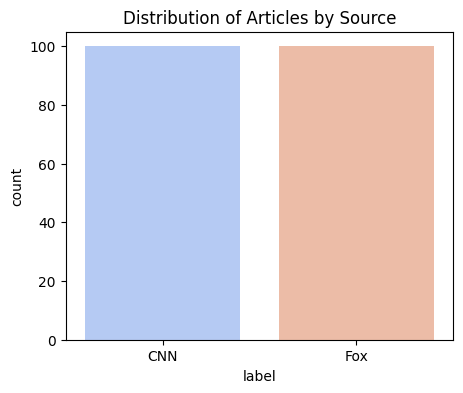

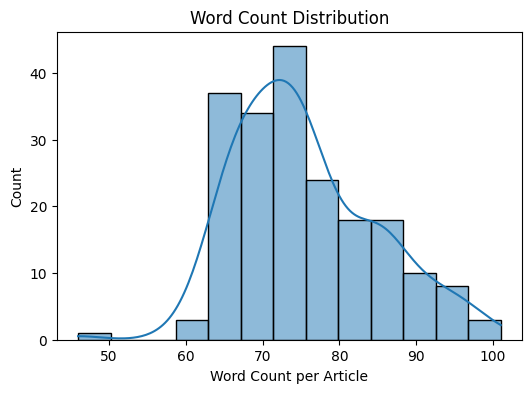


Average word count by source:
label
CNN    79.15
Fox    71.80
Name: word_count, dtype: float64


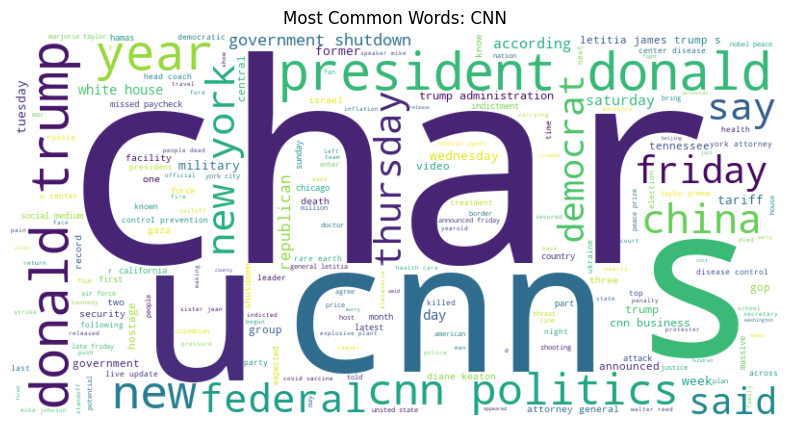

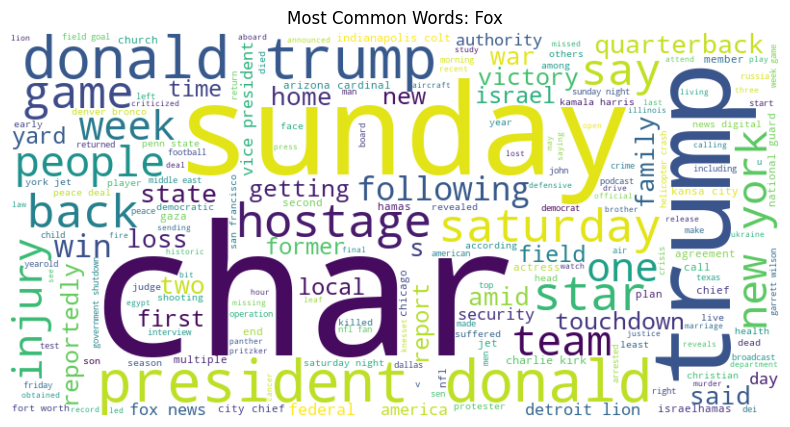

/var/folders/xl/dlcxtfx92470hfts6qf0sr6h0000gn/T/ipykernel_84569/3897197021.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="sentiment", data=df, palette="Set2")


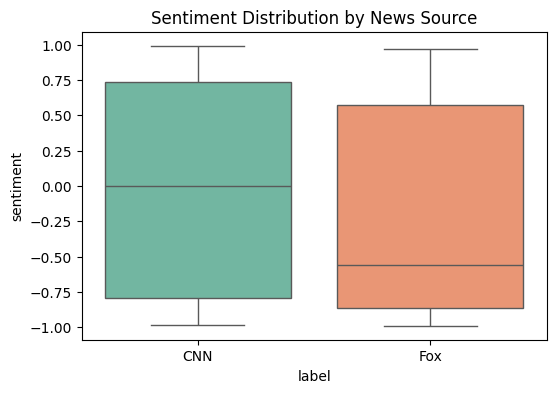


Average sentiment by source:
label
CNN   -0.045444
Fox   -0.201426
Name: sentiment, dtype: float64


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Load cleaned data
df = pd.read_csv("../data/processed/news_clean.csv")

# General Information
print(df.info())
print("\nSample rows:")
print(df.head(3))

#Labels
plt.figure(figsize=(5,4))
sns.countplot(x="label", data=df, palette="coolwarm")
plt.title("Distribution of Articles by Source")
plt.show()

# Word Counts
plt.figure(figsize=(6,4))
sns.histplot(df["word_count"], kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Word Count per Article")
plt.show()

print("\nAverage word count by source:")
print(df.groupby("label")["word_count"].mean())

#Word Clouds
for label in df["label"].unique():
    text = " ".join(df[df["label"] == label]["clean_text"].astype(str))
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Most Common Words: {label}")
    plt.show()

# Sentiment
nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()

df["sentiment"] = df["clean_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="sentiment", data=df, palette="Set2")
plt.title("Sentiment Distribution by News Source")
plt.show()

print("\nAverage sentiment by source:")
print(df.groupby("label")["sentiment"].mean())


<h2> Modeling </h2>

In [23]:
#Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
from pathlib import Path

# bring in the data
data_path = Path.cwd().parent / "data" / "processed" / "news_clean.csv"
df = pd.read_csv(data_path)
print(f"Loaded {len(df)} cleaned articles")

# Split
X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training size: {len(X_train)} | Testing size: {len(X_test)}")

# TF-IDF Vector
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# LR
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Evaluation
y_pred = clf.predict(X_test_tfidf)

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# save model and vectorizer
models_dir = Path.cwd().parent / "models"
models_dir.mkdir(exist_ok=True)

joblib.dump(clf, models_dir / "classifier_model.pkl")
joblib.dump(vectorizer, models_dir / "text_vectorizer.pkl")

print(f"\n Model and vectorizer saved to {models_dir}")


Loaded 200 cleaned articles
Training size: 160 | Testing size: 40

--- Model Evaluation ---
Accuracy: 0.7500

              precision    recall  f1-score   support

         CNN       0.73      0.80      0.76        20
         Fox       0.78      0.70      0.74        20

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40


Confusion Matrix:
[[16  4]
 [ 6 14]]

 Model and vectorizer saved to /Users/mammajamma/Projects/ADS509Final/models


In [25]:
import joblib

# Save model and vectorizer
joblib.dump(clf, "../models/classifier_model.pkl")
joblib.dump(vectorizer, "../models/text_vectorizer.pkl")

print("✅ Model and vectorizer saved successfully with joblib.")



✅ Model and vectorizer saved successfully with joblib.
